In [49]:
# Importing modules
import glob
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import zipfile
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx

In [22]:
# Defining FileFinder
def FileFinder(YKR_IDs: list, input_folder_name: str, to_file=False):
    """
    Returns a list of travel time matrix filepaths based on a list of YKR ID values
    from a specified input data folder. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    input_folder_name (str): Name of the input folder
                    to_file (boolean): If True, also returns a text file

            Returns:
                    file_paths (list): A list of filepaths
    """
    # Using assert to make sure input is ok
    assert type(YKR_IDs) == list, "The input of the YKR_ID:s needs to be a list!"
    # Finding the folder from the user's instance
    input_folder = Path(input_folder_name).absolute()
    # Using assert to make sure input folder exists
    assert os.path.isdir(input_folder) == True, "Check the input folder's name!"
    # Creating a global variable of the input folder's name
    global global_input_folder_name
    global_input_folder_name = input_folder_name
    # Defining counter
    counter = 0
    # Creating an empty list for the filepaths
    file_paths = []
    # Creating a variable for the f-string
    glob_end = "*.txt"
    # Creating a variable for glob
    glob_start = f"{input_folder_name}/**/travel_times_to_ "
    # Creating a list to check for false YKR ID's
    false_names = YKR_IDs.copy()
    # For-looping the user's folders (and subfolders) with glob
    for name in glob.glob(glob_start+glob_end, recursive=True):
        # Finding the YKR ID part of the filepath
        end_txt = name[-11:]
        end = end_txt[:-4]
        # Finding filename of the filepath
        fname = name[-28:]
        # Checking if the YKR ID of the filepath exists in input list
        if end in YKR_IDs:
            # Increasing counter
            counter += 1
            # Informing user of current progress
            print(f"Processing file {fname}. Progress: {counter}/{len(glob.glob(glob_start+glob_end, recursive=True))}")
            # Appending filepath to list
            file_paths.append(name)
            # Removing real YKR ID's from the false YKR ID list
            false_names.remove(end)
        else:
            continue
    # Informing user of false YKR ID's
    for false_ID in false_names:
        print(f"YKR ID number {false_ID} does not exist in folder: {input_folder_name}\nMake sure the YKR ID values in the input list are typed correctly.")
    # Checking for the optional parameter (default is False)
    if to_file == True:
        # Writing the list of filepaths to a text file
        with open("YKR_ID_fps", "w") as output:
            output.write(str(file_paths))
        # Informing the user of the name of the new text file
        print("Wrote the filepaths to file: YKR_ID_fps.txt")
    # Returning the list of filepaths
    return file_paths

In [25]:
# Testing the FileFinder
FileFinder(lista, "input_data")
#print(FileFinder(lista, "input_data"))

Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.


['input_data\\travel_times_to_ 5787544.txt',
 'input_data\\travel_times_to_ 5787545.txt',
 'input_data\\travel_times_to_ 5787546.txt',
 'input_data\\travel_times_to_ 5787547.txt',
 'input_data\\travel_times_to_ 5787548.txt',
 'input_data\\travel_times_to_ 5787549.txt',
 'input_data\\travel_times_to_ 5787550.txt',
 'input_data\\sub_folder\\travel_times_to_ 5990000.txt',
 'input_data\\sub_folder\\travel_times_to_ 5990001.txt',
 'input_data\\sub_folder\\travel_times_to_ 5990002.txt']

In [7]:
data = pd.read_csv(FileFinder(lista, "input_data")[8], sep=";")
data

Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.


,from_id,to_id,walk_t,walk_d,bike_s_t,bike_f_t,bike_d,pt_r_tt,pt_r_t,pt_r_d,pt_m_tt,pt_m_t,pt_m_d,car_r_t,car_r_d,car_m_t,car_m_d,car_sl_t
0,5785640,5990001,583,40784,178,113,39558,191,171,45848,208,178,45848,82,46868,71,46969,42
1,5785641,5990001,545,38168,175,111,36953,201,174,46054,214,176,46054,82,47079,71,47180,42
2,5785642,5990001,546,38247,175,111,36953,205,175,46171,214,177,46171,82,46480,71,44805,42
3,5785643,5990001,551,38540,171,108,38261,215,179,46464,214,181,46464,82,48363,71,48675,43
4,5787544,5990001,576,40294,175,111,39018,189,164,45358,198,171,45358,81,46442,70,46543,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13226,6016698,5990001,511,35755,166,105,35792,147,124,38723,140,123,38723,83,39030,72,39001,43
13227,6016699,5990001,513,35882,165,105,35769,147,126,38850,142,125,38850,83,38717,72,38689,43
13228,6018252,5990001,518,36253,169,107,36308,153,131,39221,147,130,39221,85,-1,73,-1,44
13229,6018253,5990001,516,36112,168,106,36070,149,129,39080,142,128,39080,84,39207,72,39178,44


In [3]:
# A test list for the FileFinder
lista = ["5787544", "5787545", "5787546", "5787547", "5787548", "5787549", "5787550", "1234567", "5990000", "5990001", "5990002"]

In [4]:
def TableJoiner(filepaths: list, output_folder: str):
    """
    Returns spatial layers as geopackage files with based on a list of YKR ID value filepaths
    from a specified input data folder to a specified output folder. 

            Parameters:
                    filepaths (list): A list of filepaths of YKR_ID files
                    output_folder (str): Name of the output folder

            Returns:
                    None
    """
    # Defining counter
    counter = 0
    # Using assert to make sure output_folder is ok
    assert type(output_folder) == str, "The output_folder must be a string!"
    assert os.path.isdir(output_folder) == True, "Check the output_folder's name!"
    # Reading the grid file
    grid = gpd.read_file(GridFpFinder())
    # For-looping filepaths
    for fp in filepaths:
        # Getting the ID part of the filepath
        id_txt = fp[-11:]
        YKR_ID = id_txt[:-4]
        # Reading the filepath
        data = pd.read_csv(fp, sep=";")
        # Merging the filepath with grid 
        merge = grid.merge(data, how="right", left_on="YKR_ID", right_on="from_id")
        # Creating a output path for the data with unique name
        output_fp = os.path.join(output_folder, f"{YKR_ID}.gpkg")
        # Saving the spatial layer 
        merge.to_file(output_fp, driver="GPKG")
        # Increasing counter
        counter += 1
        # Informing the user of the progress
        print(f"Processing file {YKR_ID}.gpkg. Progress: {counter}/{len(filepaths)}")

In [46]:
def TableJoiner2(YKR_IDs: list, output_folder_name: str):
    ####################################################
    """
    Returns spatial layers as geopackage files based on a list of YKR_ID numbers 
    to a specified output folder. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    output_folder (str): Name of the output folder

            Returns:
                    gpkg_files (list): A list of filepaths of the geopackage files
    """
    #######################################################
    # Defining counter
    counter = 0
    # Using assert to make sure output_folder is ok
    assert type(output_folder_name) == str, "The output_folder must be a string!"
    assert os.path.isdir(output_folder_name) == True, "Check the output_folder's name!"
    # Creating a global variable of the output folder's name
    global global_output_folder_name
    global_output_folder_name = output_folder_name
    # Reading the grid file
    grid = gpd.read_file(GridFpFinder())
    # ASSERT GLOBAL_INPUT_FOLDER_NAME = STR; MAKE SURE TO RUN FILEFINDER FIRST!######## # # # # # !
    filepaths = FileFinder(YKR_IDs, global_input_folder_name)
    # Creating an empty list for the file names
    gpkg_files = []
    # For-looping filepaths
    for fp in filepaths:
        # Getting the ID part of the filepath
        id_txt = fp[-11:]
        YKR_ID = id_txt[:-4]
        # Reading the filepath
        data = pd.read_csv(fp, sep=";")
        # Merging the filepath with grid 
        merge = grid.merge(data, how="right", left_on="YKR_ID", right_on="from_id")
        # Creating a output path for the data with unique name
        output_fp = os.path.join(output_folder_name, f"{YKR_ID}.gpkg")
        # Saving the spatial layer 
        merge.to_file(output_fp, driver="GPKG")
        # Adding the filepaths to a list
        gpkg_files.append(output_fp)
        # Increasing counter
        counter += 1
        # Informing the user of the progress
        print(f"Processing file {YKR_ID}.gpkg. Progress: {counter}/{len(filepaths)}")
    
    return gpkg_files

In [72]:
def TableJoiner3(YKR_IDs: list, output_folder_name: str):
    ####################################################
    """
    Returns spatial layers as geopackage files based on a list of YKR_ID numbers 
    to a specified output folder. 

            Parameters:
                    YKR_IDs (list): A list of YKR_ID numbers
                    output_folder (str): Name of the output folder

            Returns:
                    gpkg_files (list): A list of filepaths of the geopackage files
    """
    #######################################################
    # Using assert to make sure output_folder is ok
    assert type(output_folder_name) == str, "The output_folder must be a string!"
    assert os.path.isdir(output_folder_name) == True, "Check the output_folder's name!"
    # Creating a global variable of the output folder's name
    global global_output_folder_name
    global_output_folder_name = output_folder_name
    # Reading the grid file
    grid = gpd.read_file(GridFpFinder())
    # ASSERT GLOBAL_INPUT_FOLDER_NAME = STR; MAKE SURE TO RUN FILEFINDER FIRST!######## # # # # # !
    filepaths = FileFinder(YKR_IDs, global_input_folder_name)
    # Creating an empty list for the file names
    gpkg_files = []
    # For-looping filepaths
    for fp in filepaths:
        
        # Getting the ID part of the filepath
        id_txt = fp[-11:]
        YKR_ID = id_txt[:-4]
        # Checking if files already exist
        fname = os.path.join(output_folder_name, f"{YKR_ID}.gpkg")
        my_file = Path(fname)
        if my_file.is_file():
            # Appending filepaths to the list
            gpkg_files.append(fname)
            continue
            
        else:
            # Reading the filepath
            data = pd.read_csv(fp, sep=";")
            # Merging the filepath with grid 
            merge = grid.merge(data, how="right", left_on="YKR_ID", right_on="from_id")
            # Creating a output path for the data with unique name
            output_fp = os.path.join(output_folder_name, f"{YKR_ID}.gpkg")
            # Saving the spatial layer 
            merge.to_file(output_fp, driver="GPKG")
            # Adding the filepaths to a list
            gpkg_files.append(output_fp)

    print(f"TableJoiner is done, geopackage files can be found in: {output_folder_name}")
    return gpkg_files

In [73]:
TableJoiner3(lista, "output_folder")


Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
TableJoiner is done, geopackage files can be found in: output_folder


['output_folder\\5787544.gpkg',
 'output_folder\\5787545.gpkg',
 'output_folder\\5787546.gpkg',
 'output_folder\\5787547.gpkg',
 'output_folder\\5787548.gpkg',
 'output_folder\\5787549.gpkg',
 'output_folder\\5787550.gpkg',
 'output_folder\\5990000.gpkg',
 'output_folder\\5990001.gpkg',
 'output_folder\\5990002.gpkg']

In [5]:
def GridFpFinder():
    """
    Returns the YKR grid filepath from the current directory.
    """
    # Defining flag
    flag = False
    # Getting current directory
    p = Path().absolute()
    # For-looping current directory
    for root, dirs, files in os.walk(p):
        for file in files:
            # Looking for the grid file
            if file.endswith('.shp'):
                if file == "MetropAccess_YKR_grid_EurefFIN.shp":
                    # Creating a filepath of the grid file
                    fullpath = os.path.join(root, file)
                    grid_fp = os.path.abspath(fullpath)
                    # Changing flag value
                    flag = True
    # Checking flag value
    if flag == False:
        # Raising an error
        raise OSError(f"Grid file: MetropAccess_YKR_grid_EurefFIN.shp does not exist in current working directory!\n{p}")
    # Returning the grid's filepath
    return grid_fp

In [124]:
print(GridFpFinder())

C:\Users\zuzzuz\Desktop\PYQGIS_101\AUTOGIS_PACKAGE\final-assignment-pjustus\grid_file\MetropAccess_YKR_grid\MetropAccess_YKR_grid_EurefFIN.shp


In [6]:
# Defining unzip
def unzip(zip_file: str, target_folder: str):
    """
    Extracts selected file to a selected directory. 

            Parameters:
                    zip_file (str): Name of the zip file
                    target_dir (str): Name of the target directory

            Returns:
                    None
    """
    # Reading zipfile
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        # Extracting zipfile to target folder
        zip_ref.extractall(target_folder)
        # Informing user of the progress
        print(f"File: {zip_file} extracted to: {target_folder}.")

In [122]:
# Testing unzip
unzip("MetropAccess_YKR_grid.zip", "grid_file")

File: MetropAccess_YKR_grid.zip extracted to: grid_file.


In [49]:
unzip("HelsinkiRegion_TravelTimeMatrix2018.zip", "TTM_files")

File: HelsinkiRegion_TravelTimeMatrix2018.zip extracted to: TTM_files.


In [87]:
def Visualizer(YKR_IDs: list, output_folder: str, travel_mode: str, map_type: str):
    #NO DATA VALUET POIS VISUALISOINNEISTA
    
    # Getting the filepaths to the geopackage files
    gpkg_fps = TableJoiner3(YKR_IDs, global_output_folder_name)
    # # # STATIC # # #
    if map_type == "static":
    
        # travel_mode == "car"
        if travel_mode == "car":
        
            for fp in gpkg_fps:
                
                name = fp[:-5]
                YKR_ID = name[-7:]

                data = gpd.read_file(fp)
                
                # Change CRS
                data = data.to_crs(epsg=3857)
                
                # Dealing with no data values
                clean_data = data.loc[data["car_r_t"] > -1]
                
                fig, ax = plt.subplots(figsize=(12, 8))
                
                credits = f"Travel time data to YKR ID {YKR_ID} by car in rush hour by Digital Geography Lab 2018, Map Data © OpenStreetMap contributors"
                
                # Plotting the data
                clean_data.plot(ax=ax,
                          column="car_r_t",
                          cmap="RdYlBu",
                          linewidth=0,
                          scheme="quantiles",
                          k=9,
                          alpha=0.5
                         )

                # Adding basemap
                ctx.add_basemap(ax, 
                               source=ctx.providers.OpenStreetMap.Mapnik,
                                attribution=credits
                               )
                
                #ax.set_xlim(2760000, 2800000)
                #ax.set_ylim(8430000, 8470000)
                
                # Creating a output path for the map with unique name
                outfp = os.path.join(output_folder, f"car_r_t_to_{YKR_ID}_static_map.png")
                # Saving figure
                plt.savefig(outfp, dpi=300)
                
                
                #print(clean_data)

                break







        #elif travel_mode == "pt":

        #elif travel_mode == "bike":

        #elif travel_mode == "walk":

        else:
            print("Check the spelling of travel_mode parameter!")



            
    # # # INTERACTIVE # # #
    #if map_type == "interactive":
    
    
        #if travel_mode == "car":








        #elif travel_mode == "pt":

        #elif travel_mode == "bike":

        #elif travel_mode == "walk":

        #else:
            #print("Check the spelling of travel_mode parameter!")

        #for fp in gpkg_fps:

            #data = gpd.read_file(fp)

            #print(data)

            #break
        
    else:
        print("Check the spelling of map_type parameter!")
        
    
    

Processing file travel_times_to_ 5787544.txt. Progress: 1/10
Processing file travel_times_to_ 5787545.txt. Progress: 2/10
Processing file travel_times_to_ 5787546.txt. Progress: 3/10
Processing file travel_times_to_ 5787547.txt. Progress: 4/10
Processing file travel_times_to_ 5787548.txt. Progress: 5/10
Processing file travel_times_to_ 5787549.txt. Progress: 6/10
Processing file travel_times_to_ 5787550.txt. Progress: 7/10
Processing file travel_times_to_ 5990000.txt. Progress: 8/10
Processing file travel_times_to_ 5990001.txt. Progress: 9/10
Processing file travel_times_to_ 5990002.txt. Progress: 10/10
YKR ID number 1234567 does not exist in folder: input_data
Make sure the YKR ID values in the input list are typed correctly.
TableJoiner is done, geopackage files can be found in: output_folder


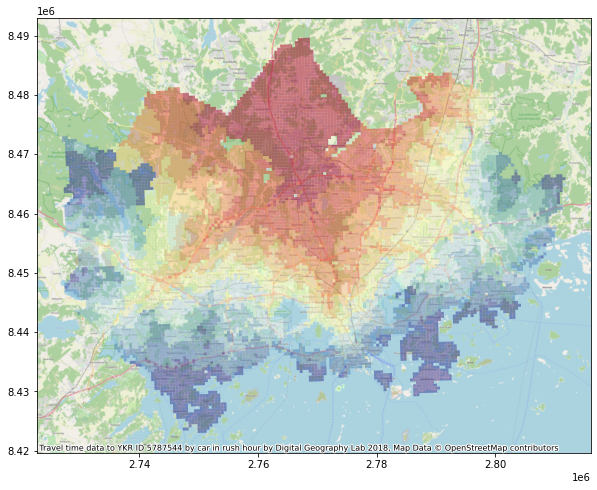

In [88]:
Visualizer(lista, "output_folder", "car", "static")

In [4]:
def ComparisonTool():

SyntaxError: unexpected EOF while parsing (<ipython-input-4-c7fae3c3a60c>, line 1)